In [45]:
import torch
import torch.nn as nn
from torchvision import transforms, models
import matplotlib.pyplot as plt
import numpy as np
import cv2
from torchvision.models import VGG16_Weights
from PIL import Image

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

model.classifier[6] = nn.Linear(4096, 15)
model.load_state_dict(torch.load('../../../model/9517/vgg16_model_Aerial_Landscapeswss_augmentation.pth'))
model.eval()
model = model.to(device)

In [47]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Register hooks
        target_layer.register_forward_hook(self.save_activations)
        target_layer.register_backward_hook(self.save_gradients)

    def save_activations(self, module, input, output):
        self.activations = output.detach()

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate(self, input_image, class_idx=None):
        # Forward pass
        output = self.model(input_image)
        if class_idx is None:
            class_idx = torch.argmax(output).item()
        
        # Backward pass for specific class
        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0][class_idx] = 1
        output.backward(gradient=one_hot)
        
        # Calculate weights
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activations = self.activations[0]
        
        # Weight activations by gradients
        for i in range(activations.shape[0]):
            activations[i, :, :] *= pooled_gradients[i]
        
        heatmap = torch.mean(activations, dim=0).cpu().numpy()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap)  # Normalize
        
        return heatmap

# Initialize for VGG16 (last conv layer: features[28])
target_layer = model.features[28]
gradcam = GradCAM(model, target_layer)

In [48]:
def add_noise(image_tensor, noise_factor=0.1):
    noise = torch.randn_like(image_tensor) * noise_factor
    return torch.clamp(image_tensor + noise, 0, 1)

def add_blur(image_tensor, kernel_size=5):
    image_np = image_tensor.numpy().transpose(1, 2, 0)
    blur_np = cv2.GaussianBlur(image_np, (kernel_size, kernel_size), 0)
    return torch.from_numpy(blur_np.transpose(2, 0, 1))

def add_occlusion(image_tensor, occ_size=50):
    occluded = image_tensor.clone()
    h, w = occluded.shape[1:]
    x = np.random.randint(0, w - occ_size)
    y = np.random.randint(0, h - occ_size)
    occluded[:, y:y+occ_size, x:x+occ_size] = 0
    return occluded
    
# Preprocessing
preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomRotation(20),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


In [49]:
def visualize_results(original_img, perturbations):
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    
    # Process original image
    orig_tensor = preprocess(original_img).unsqueeze(0)
    with torch.no_grad():
        orig_pred = torch.softmax(model(orig_tensor), dim=1)
    orig_heatmap = gradcam.generate(orig_tensor)
    
    # Plot original
    axes[0,0].imshow(original_img)
    axes[0,0].set_title(f"Original\nPred: {orig_pred.argmax().item()}")
    axes[1,0].imshow(orig_heatmap, cmap='jet', alpha=0.5)
    axes[1,0].set_title("Grad-CAM")
    
    # Process perturbations
    for idx, (name, func) in enumerate(perturbations.items(), start=1):
        # Apply perturbation
        pert_tensor = func(orig_tensor.clone())
        
        # Get predictions
        with torch.no_grad():
            pert_pred = torch.softmax(model(pert_tensor), dim=1)
        
        # Generate heatmap
        pert_heatmap = gradcam.generate(pert_tensor)
        
        # De-normalize for display
        img = pert_tensor.squeeze().permute(1,2,0).numpy()
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        
        # Plot
        axes[0,idx].imshow(img)
        axes[0,idx].set_title(f"{name}\nPred: {pert_pred.argmax().item()}")
        axes[1,idx].imshow(pert_heatmap, cmap='jet', alpha=0.5)
    
    plt.tight_layout()
    plt.show()


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

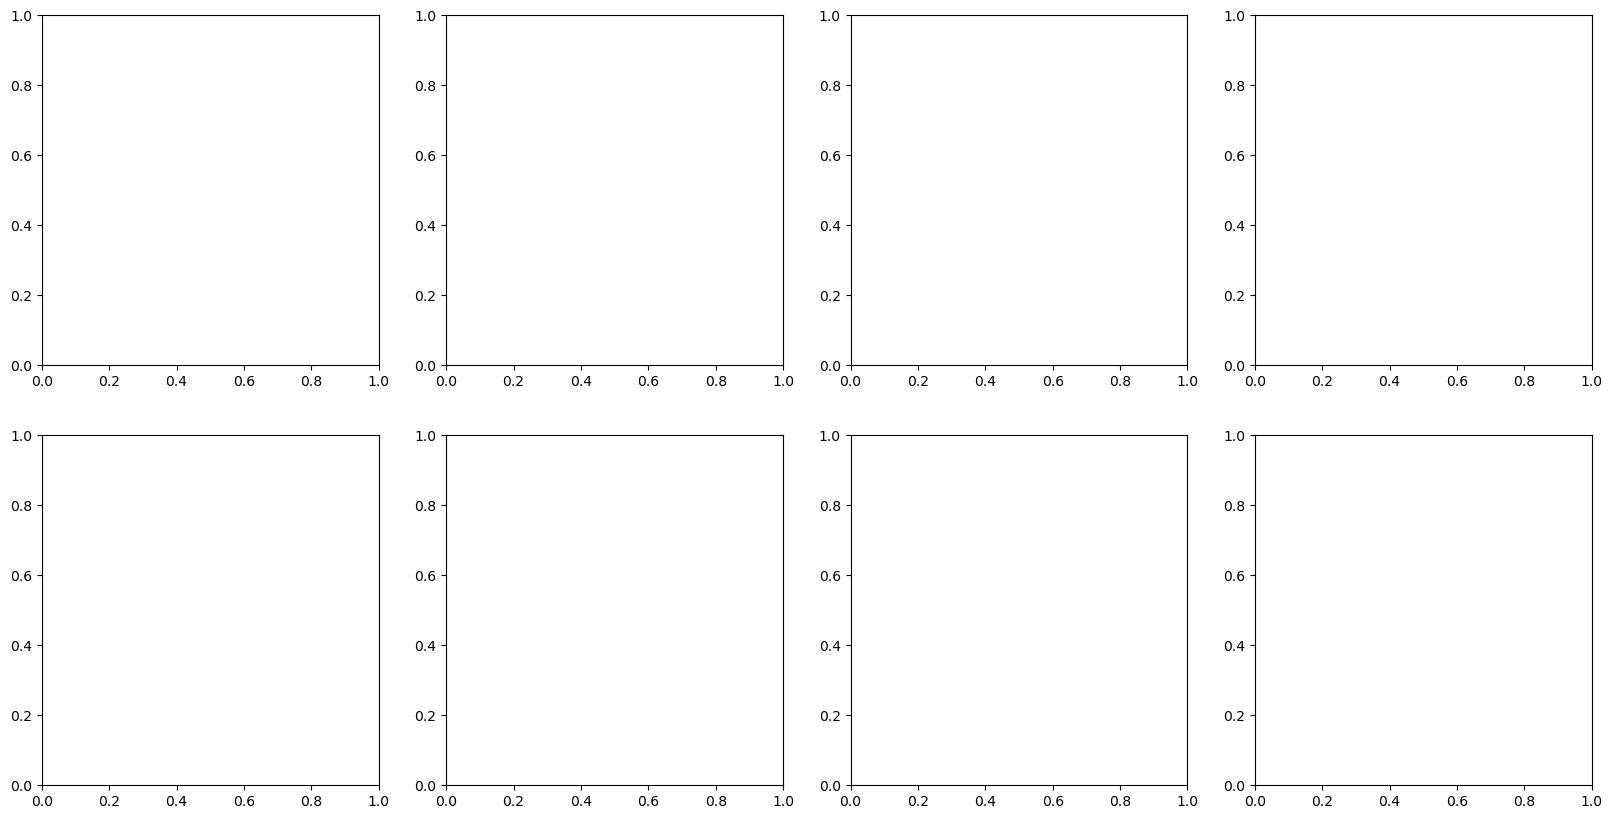

In [50]:
# Example usage
original_img = Image.open("../../archive/Aerial_Landscapes/Agriculture/012.jpg")
perturbations = {
    "Gaussian Noise": lambda x: add_noise(x, 0.2),
    "Motion Blur": lambda x: add_blur(x, 15),
    "Occlusion": lambda x: add_occlusion(x, 80)
}

visualize_results(original_img, perturbations)